In [1]:
import skimage
import skimage.io
import skimage.segmentation

from skimage import feature
from skimage import color
from skimage import filters

from skimage.filters import threshold_otsu, sobel
from skimage.measure import label, regionprops
from skimage.feature import peak_local_max

from skimage.morphology import *
from scipy import ndimage as ndi

import numpy as np

import matplotlib.pyplot as plt

from scipy.ndimage.morphology import distance_transform_edt

def show_image(img):
    """
    Show a single image
    """
    fig = plt.figure(figsize = (15,10))
    plt.imshow(img)

def save_image(img, name):
    skimage.io.imsave(name, img)

In [2]:
def otsu_image(image):
    gray = 1 - image
    threshold = threshold_otsu(gray)

    return binary_dilation(gray > threshold)

In [3]:
def filter_noise(img, threshold=0.3, m_w=40):
    label_image = label(img)

    for i, region in enumerate(regionprops(label_image)):
        bbox = region.bbox
        h = bbox[2] - bbox[0]
        w = bbox[3] - bbox[1]

        ratio = region.minor_axis_length / region.major_axis_length

        box = label_image[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        
        if ratio < threshold or max(h, w) > m_w or region.extent < threshold or min(w, h) / max(w, h) < threshold:
            sm = img[bbox[0]:bbox[2],bbox[1]:bbox[3]]
            sm[box == i + 1] = 0
            continue

    return img

In [62]:
def preprocess_image(image, grid, exterior):
    binary = binary_closing(np.any(otsu_image(image), axis=2))
    original = binary.copy()
    binary = binary ^ filter_noise(binary ^ remove_small_objects(binary, 5000), threshold=0.1, m_w=100)
    binary[exterior > 0] = 0
    binary[grid > 0] = 0

    binary = binary ^ filter_noise(binary ^ remove_small_objects(binary, 5000) ^ (binary ^ remove_small_objects(binary, 100)))
    #binary = binary_closing(binary, disk(10))
    binary = remove_small_objects(binary, 100)

    return original, binary

In [149]:
def dist_map(binary, exterior):
    binary = 1 - binary

    distance = ndi.distance_transform_edt(binary)

    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=binary)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=binary)

    labels = labels + 1
    labels[exterior > 0] = 0

    n_dist = distance.copy()

    for i, reg in enumerate(regionprops(labels)):
        bbox = reg.bbox

        label_box = labels[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        dists_box = n_dist[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        
        label_filter = label_box == (i + 1)

        if dists_box[label_filter].shape[0] == 0:
            print("euh")
            continue
        
        h = bbox[2] - bbox[0]
        w = bbox[3] - bbox[1]

        val = np.max(dists_box[label_filter])
        dists_box[label_filter] = val

    return n_dist

In [6]:
def filter_roads(binary, n_dist, exterior):
    n_binary = binary.copy()
    n_binary[exterior > 0] = 1
    n_binary[n_dist < 10] = 1
    n_binary[n_dist > 100] = 1
    n_binary = remove_small_holes(n_binary, 800000)

    return n_binary

In [108]:
img = "002"
image = skimage.io.imread(f"results/{img}/02_preprocessed.png")
grid = skimage.io.imread(f"results/{img}/01_grid.png")
exterior = skimage.io.imread(f"results/{img}/01_exterior.png") 

In [109]:
original, binary = preprocess_image(image, grid, exterior)

<ipython-input-2-427c43ee27e1>:3: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (6716, 6311, 3) looks like an RGB image
  threshold = threshold_otsu(gray)


In [150]:
n_dist = dist_map(binary, exterior)

euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh
euh


In [151]:
n_binary = filter_roads(binary, n_dist, exterior)

In [152]:
edges = filters.sobel(n_dist)
edges[exterior > 0] = 11

edges = edges > 20
edges[n_dist > 300] = True

In [153]:
edges = remove_small_holes(edges, 1000)

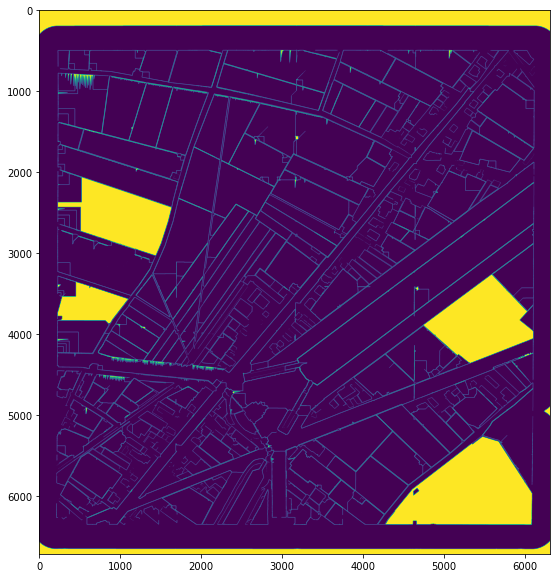

In [154]:
show_image(edges)

In [115]:
bin_fi = np.any(otsu_image(image), axis=2)

<ipython-input-2-427c43ee27e1>:3: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (6716, 6311, 3) looks like an RGB image
  threshold = threshold_otsu(gray)


In [15]:
r = bin_fi * 255 - binary_dilation(v > 10, square(5)) * 255
r[r < 0] = 0
r[grid > 0] = 0
r[exterior > 0] = 0

show_image(r)

NameError: name 'v' is not defined

In [ ]:
save_image((v > 10) * 255, "coucou.png")

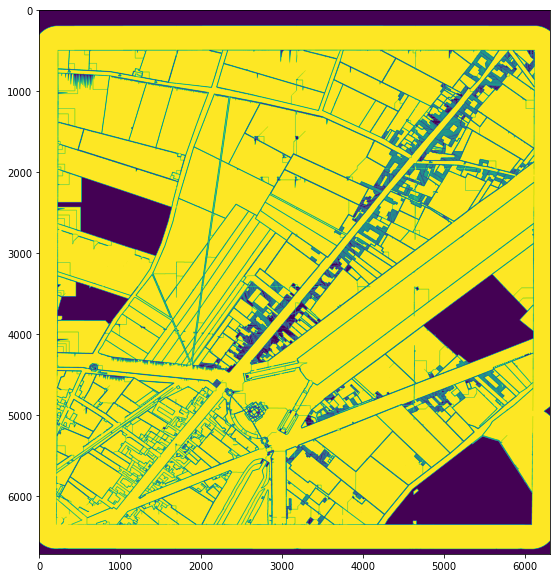

In [155]:
v2 = binary.copy()
v2[edges > 0] = True
show_image(1 - v2)

In [156]:
v2[exterior > 0] = 1
labels = label(1 - v2, connectivity=1)

for i, reg in enumerate(regionprops(labels)):
    bbox = reg.bbox

    h = bbox[2] - bbox[0]
    w = bbox[3] - bbox[1]

    ratio = reg.minor_axis_length / max(reg.major_axis_length, 1)
    
    if reg.perimeter > 4000 and (reg.perimeter / reg.area) < 0.1:
        continue

    if ratio < 0.1 and reg.minor_axis_length > 20.0:
        continue
        
    if max(w, h) < 2000 and (w + h) < 3000:
        label_box = labels[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        dists_box = v2[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        
        label_filter = label_box == (i + 1)

        dists_box[label_filter] = 1

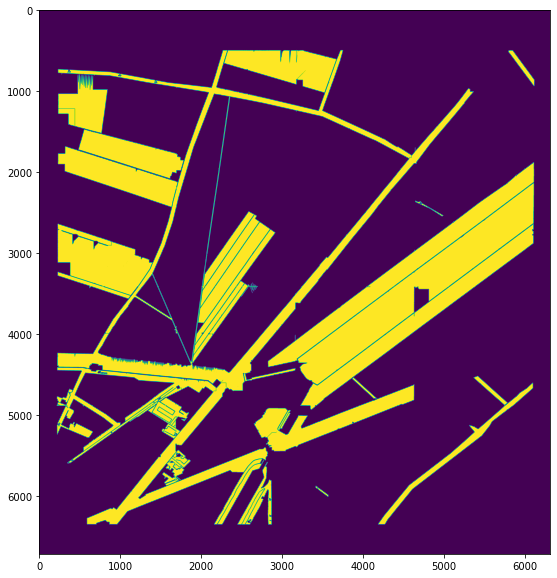

In [157]:
show_image(1 - v2)

In [78]:
save_image(binary*255, "coucou.png")

<ipython-input-1-b959cc32a91e>:30: UserWarning: coucou.png is a low contrast image
  skimage.io.imsave(name, img)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


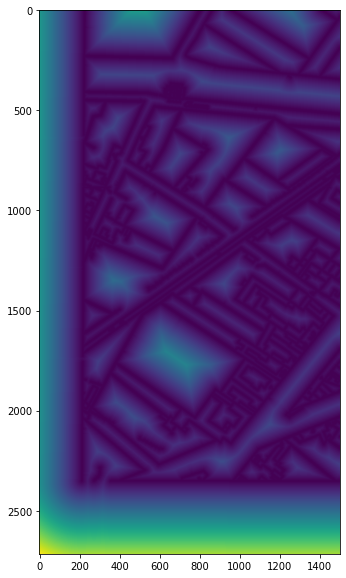

In [138]:
show_image(ndi.distance_transform_edt(1 - binary[4000:,:1500]))

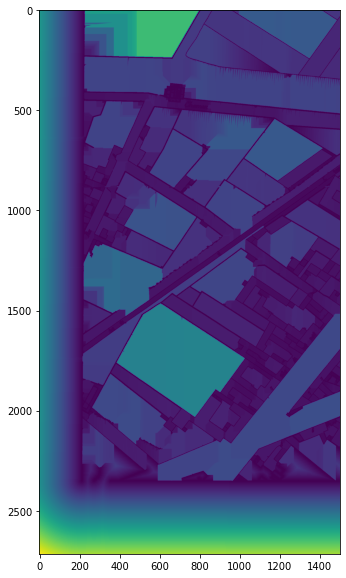

In [158]:
show_image(n_dist[4000:,:1500])